# Federated 2d XRay registration with MONAI

## Introduction

This tutorial shows how to deploy in Fed-BioMed the 2d image registration example provided in the project MONAI (https://monai.io/):

https://github.com/Project-MONAI/tutorials/blob/master/2d_registration/registration_mednist.ipynb

Being MONAI based on PyTorch, the deployment within Fed-BioMed follows seamlessy the same general structure of general PyTorch models. 

Following the MONAI example, this tutorial is based on the MedNIST dataset>



## Image Registration

Image registration is the process of transforming and recalibrating different images into one coordinate system. It makes possible to compare several images captured with the same modality.

In this tutorial, we are using a UNet-like registration network ( https://arxiv.org/abs/1711.01666 ).
Goal of the notebook is to train a model given moving images and fixed images (recalibrated images). 

## Creating MedNIST nodes

MedNIST provides an artificial 2d classification dataset created by gathering different medical imaging datasets from TCIA, the RSNA Bone Age Challenge, and the NIH Chest X-ray dataset. The dataset is kindly made available by Dr. Bradley J. Erickson M.D., Ph.D. (Department of Radiology, Mayo Clinic) under the Creative Commons CC BY-SA 4.0 license.

To proceed with the tutorial, we created an iid partitioning of the MedNIST dataset between 3 clients. Each client has 3000 image samples for each class. The training partitions are availables at the following link:

https://drive.google.com/file/d/1vLIcBdtdAhh6K-vrgCFy_0Y55dxOWZwf/view

The dataset owned by each client has structure:


└── client_*/

    ├── AbdomenCT/
    
    └── BreastMRI/
    
    └── CXR/
    
    └── ChestCT/
    
    └── Hand/
    
    └── HeadCT/      

To create the federated dataset, we follow the standard procedure for node creation/population of Fed-BioMed. 
After activating the fedbiomed network with the commands

`source ./scripts/fedbiomed_environment network`

and 

`./scripts/fedbiomed_run network`

we create a first node by using the commands

`source ./scripts/fedbiomed_environment node`

`./scripts/fedbiomed_run node start`

We then poulate the node with the data of first client:

`./scripts/fedbiomed_run node add`

We select option 3 (images) to add MedNIST partition of client 1, by just picking the folder of client 1. We use `mednist` as tag to save the selected dataset.
We can further check that the data has been added by executing `./scripts/fedbiomed_run node list`

Following the same procedure, we create the other two nodes with the datasets of client 2 and client 3 respectively.


## Running Fed-BioMed Researcher

We are now ready to start the reseracher enviroment with the command `source ./scripts/fedbiomed_environment researcher`, and open the Jupyter notebook with `./scripts/fedbiomed_run researcher`. 

We can first quesry the network for the mednist dataset. In this case, the nodes are sharing the respective partitions unsing the same tag `mednist`:

In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
from fedbiomed.researcher.requests import Requests
req = Requests()
req.list(verbose=True)

2022-01-07 16:40:34,811 fedbiomed INFO - Component environment:
2022-01-07 16:40:34,812 fedbiomed INFO - - type = ComponentType.RESEARCHER
2022-01-07 16:40:35,115 fedbiomed INFO - Messaging researcher_9a5e90fe-9b66-4171-8e59-22b41d5060a6 successfully connected to the message broker, object = <fedbiomed.common.messaging.Messaging object at 0x7ff830580d60>
2022-01-07 16:40:35,157 fedbiomed INFO - Listing available datasets in all nodes... 
2022-01-07 16:40:35,159 fedbiomed INFO - log from: node_da3ddd31-2d68-45ab-8d28-f9283b51ee19 / DEBUG - Message received: {'researcher_id': 'researcher_9a5e90fe-9b66-4171-8e59-22b41d5060a6', 'command': 'list'}
2022-01-07 16:40:35,169 fedbiomed INFO - log from: node_0882b2a2-a0a1-4711-b474-46ddd3504168 / DEBUG - Message received: {'researcher_id': 'researcher_9a5e90fe-9b66-4171-8e59-22b41d5060a6', 'command': 'list'}
2022-01-07 16:40:35,171 fedbiomed INFO - log from: node_486605b6-9bc7-436c-9220-ab50a4be75be / DEBUG - Message received: {'researcher_id': '

{'node_da3ddd31-2d68-45ab-8d28-f9283b51ee19': [{'name': 'mednist',
   'data_type': 'images',
   'tags': ['mednist'],
   'description': '',
   'shape': [18000, 3, 64, 64]}],
 'node_0882b2a2-a0a1-4711-b474-46ddd3504168': [{'name': 'mednist',
   'data_type': 'images',
   'tags': ['mednist'],
   'description': '',
   'shape': [18000, 3, 64, 64]}],
 'node_486605b6-9bc7-436c-9220-ab50a4be75be': [{'name': 'mednist',
   'data_type': 'images',
   'tags': ['mednist'],
   'description': '',
   'shape': [16954, 3, 64, 64]}]}

## Create an experiment to train a model on the data found

The code for network and data loader of the MONAI tutorial can now be deployed in Fed-BioMed.
We first import the necessary modules from `fedbiomed` and `monai` libraries:

In [1]:
from fedbiomed.researcher.environ import environ
import tempfile
tmp_dir_model = tempfile.TemporaryDirectory(dir=environ['TMP_DIR']+'/')
model_file = tmp_dir_model.name + '/class_export_mednist.py'

2022-01-07 16:56:27,838 fedbiomed INFO - Component environment:
2022-01-07 16:56:27,839 fedbiomed INFO - - type = ComponentType.RESEARCHER


In [2]:
from monai.utils import set_determinism, first
from monai.transforms import (
    EnsureChannelFirstD,
    Compose,
    LoadImageD,
    RandRotateD,
    RandZoomD,
    ScaleIntensityRanged,
    EnsureTypeD,
)
from monai.data import DataLoader, Dataset, CacheDataset
from monai.config import print_config, USE_COMPILED
from monai.networks.nets import GlobalNet
from monai.networks.blocks import Warp
from monai.apps import MedNISTDataset

We can now define the training plan. Note that we use the standard `TorchTrainingPlan` natively provided in Fed-BioMed. We reuse the `MedNISTDataset` data loader defined in the original MONAI tutorial, which is returned by the method `training_data`, which also implements the data parsing from the nodes `dataset_path`. We should also properly define the `training_routine`, following the MONAI tutorial. According to the MONAI tutorial, the model is the `GlobalNet` and the loss is `MSELoss`.

In [3]:
%%writefile "$model_file"

import os
import numpy as np
import torch
from torch.nn import MSELoss
import torch.nn as nn
from fedbiomed.common.torchnn import TorchTrainingPlan
from fedbiomed.common.logger import logger
from torchvision import datasets, transforms
from typing import Union, List

from monai.utils import set_determinism, first
from monai.transforms import (
    EnsureChannelFirstD,
    Compose,
    LoadImageD,
    RandRotateD,
    RandZoomD,
    ScaleIntensityRanged,
    EnsureTypeD,
)
from monai.data import DataLoader, Dataset, CacheDataset
from monai.config import print_config, USE_COMPILED
from monai.networks.nets import GlobalNet
from monai.networks.blocks import Warp
from monai.apps import MedNISTDataset

# Here we define the model to be used. 
class MyMonaiTrainingPlan(TorchTrainingPlan):
    def __init__(self):
        super(MyMonaiTrainingPlan, self).__init__()
        
        # Here we define the custom dependencies that will be needed by our custom Dataloader
        # In this case, we need the torch DataLoader classes
        # Since we will train on MNIST, we need datasets and transform from torchvision
        deps = ["import numpy as np",
                "import os",
                "from fedbiomed.common.logger import logger",
                "from torch.nn import MSELoss",
                "from typing import Union, List",
                "from monai.utils import set_determinism, first",
                "from monai.transforms import (EnsureChannelFirstD,Compose,LoadImageD,RandRotateD,RandZoomD,ScaleIntensityRanged,EnsureTypeD,)",
                "from monai.data import DataLoader, Dataset, CacheDataset",
                "from monai.config import print_config, USE_COMPILED",
                "from monai.networks.nets import GlobalNet",
                "from monai.networks.blocks import Warp",
                "from monai.apps import MedNISTDataset",]
        self.add_dependency(deps)
        
        use_cuda = torch.cuda.is_available()
        
        
        self.model = GlobalNet(
            image_size=(64, 64),
            spatial_dims=2,
            in_channels=2,  # moving and fixed
            num_channel_initial=16,
            depth=3)#.to(self.device)
        self.image_loss = MSELoss()
        
        if USE_COMPILED:
            self.warp_layer = Warp(3, "border")
        else:
            self.warp_layer = Warp("bilinear", "border")
            
        self.optimizer = torch.optim.Adam(self.model.parameters(), 1e-5)
        
    def training_data(self, batch_size = 20):
        # Custom torch Dataloader for MedNIST data
        data_path = self.dataset_path
        # The following line is needed if client structure does not contain the "/MedNIST" folder
        MedNISTDataset.dataset_folder_name = ""
        train_data = MedNISTDataset(root_dir=data_path, section="training", download=False, transform=None)
        training_datadict = [
            {"fixed_hand": item["image"], "moving_hand": item["image"]}
            for item in train_data.data if item["label"] == 4  # label 4 is for xray hands
        ]
        train_transforms = Compose(
            [
                LoadImageD(keys=["fixed_hand", "moving_hand"]),
                EnsureChannelFirstD(keys=["fixed_hand", "moving_hand"]),
                ScaleIntensityRanged(keys=["fixed_hand", "moving_hand"],
                                     a_min=0., a_max=255., b_min=0.0, b_max=1.0, clip=True,),
                RandRotateD(keys=["moving_hand"], range_x=np.pi/4, prob=1.0, keep_size=True, mode="bicubic"),
                RandZoomD(keys=["moving_hand"], min_zoom=0.9, max_zoom=1.1,
                          monaiprob=1.0, mode="bicubic", align_corners=False),
                EnsureTypeD(keys=["fixed_hand", "moving_hand"]),
            ]
        )
        train_ds = CacheDataset(data=training_datadict[:1000], transform=train_transforms,
                                cache_rate=1.0, num_workers=0)
        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
        
        return train_loader

    def forward(self, x):
        return self.model(x)
    
    def training_step(self, moving, fixed):
        ddf = self.forward(torch.cat((moving, fixed), dim=1))
        pred_image = self.warp_layer(moving, ddf)
        loss = self.image_loss(pred_image, fixed)
        return loss
    
    def training_routine(self,
                         epochs: int = 2,
                         log_interval: int = 10,
                         lr: Union[int, float] = 1e-3,
                         batch_size: int = 48,
                         batch_maxnum: int = 0,
                         dry_run: bool = False,
                         monitor=None):
        
        if self.optimizer is None:
            self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)

        self.model.to(self.device)
        
        training_data = self.training_data(batch_size=batch_size)

        for epoch in range(1, epochs + 1):
            self.model.train()
            for batch_idx, batch_data in enumerate(training_data):
                self.optimizer.zero_grad()
                moving = batch_data["moving_hand"].to(self.device)
                fixed = batch_data["fixed_hand"].to(self.device)
                res = self.training_step(moving, fixed)
                res.backward()
                self.optimizer.step()

                # do not take into account more than batch_maxnum
                # batches from the dataset
                if (batch_maxnum > 0) and (batch_idx >= batch_maxnum):
                    logger.debug('Reached {} batches for this epoch, ignore remaining data'.format(batch_maxnum))
                    break

                if batch_idx % log_interval == 0:
                    logger.info('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        epoch,
                        batch_idx * len(moving),
                        len(training_data.dataset),
                        100 * batch_idx / len(training_data),
                        res.item()))

                    # Send scalar values via general/feedback topic
                    if monitor is not None:
                        monitor.add_scalar('Loss', res.item(), batch_idx, epoch)

                    if dry_run:
                        return

Writing /home/ybouilla/fedbiomed/var/tmp/tmpitp9ruvj/class_export_mednist.py


We now set the model and training parameters. Note that in this case, no model argument is required.

In [4]:
model_args = {}

training_args = {
    'batch_size': 16, 
    'lr': 1e-5, 
    'epochs': 3, 
    'dry_run': False,  
    'batch_maxnum':250 # Fast pass for development : only use ( batch_maxnum * batch_size ) samples
}

The experiment can be now defined, by providing the `mednist` tag, and running the local training on nodes with model defined in `model_path`, standard `aggregator` (FedAvg) and `client_selection_strategy` (all nodes used). Federated learning is going to be perfomed through 5 optimization rounds.

In [5]:
from fedbiomed.researcher.experiment import Experiment
from fedbiomed.researcher.aggregators.fedavg import FedAverage

tags =  ['mednist']
rounds = 5

exp = Experiment(tags=tags,
                 #clients=None,
                 model_path=model_file,
                 model_args=model_args,
                 model_class='MyMonaiTrainingPlan',
                 training_args=training_args,
                 rounds=rounds,
                 aggregator=FedAverage(),
                 node_selection_strategy=None
                )

2022-01-07 16:56:36,826 fedbiomed INFO - Messaging researcher_9a5e90fe-9b66-4171-8e59-22b41d5060a6 successfully connected to the message broker, object = <fedbiomed.common.messaging.Messaging object at 0x7fc3ba6cddc0>
2022-01-07 16:56:36,883 fedbiomed INFO - Searching dataset with data tags: ['mednist'] for all nodes
2022-01-07 16:56:36,885 fedbiomed INFO - log from: node_486605b6-9bc7-436c-9220-ab50a4be75be / DEBUG - Message received: {'researcher_id': 'researcher_9a5e90fe-9b66-4171-8e59-22b41d5060a6', 'tags': ['mednist'], 'command': 'search'}
2022-01-07 16:56:36,886 fedbiomed INFO - log from: node_da3ddd31-2d68-45ab-8d28-f9283b51ee19 / DEBUG - Message received: {'researcher_id': 'researcher_9a5e90fe-9b66-4171-8e59-22b41d5060a6', 'tags': ['mednist'], 'command': 'search'}
2022-01-07 16:56:36,886 fedbiomed INFO - log from: node_0882b2a2-a0a1-4711-b474-46ddd3504168 / DEBUG - Message received: {'researcher_id': 'researcher_9a5e90fe-9b66-4171-8e59-22b41d5060a6', 'tags': ['mednist'], 'comma

Let's start the experiment.

By default, this function doesn't stop until all the `rounds` are done for all the clients

In [ ]:
exp.run()

## Testing


Once the federated model is obtained, it is possible to test it locally on an independent testing partition.
The test dataset is available at this link:

https://drive.google.com/file/d/1YbwA0WitMoucoIa_Qao7IC1haPfDp-XD/

Following the Monai tutorial, in this section we will create a set of previously unseen pairs of moving vs fixed hands, and use the final federated model to predict the transformation between each pair.

In [ ]:
!pip install matplotlib
!pip install gdown

In [8]:
import os
import tempfile
import PIL
import torch
import numpy as np
import matplotlib.pyplot as plt
import gdown
import zipfile
import matplotlib.pyplot as plt

print_config()
set_determinism(42)

MONAI version: 0.8.0
Numpy version: 1.21.2
Pytorch version: 1.8.1+cu102
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 714d00dffe6653e21260160666c4c201ab66511b

Optional dependencies:
Pytorch Ignite version: 0.4.6
Nibabel version: 3.2.1
scikit-image version: 0.19.0
Pillow version: 8.4.0
Tensorboard version: 2.7.0
gdown version: 4.2.0
TorchVision version: 0.9.1+cu102
tqdm version: 4.62.3
lmdb version: 1.2.1
psutil version: 5.8.0
pandas version: 1.3.5
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



Download the testing dataset on the local temporary folder.

In [9]:
resource = "https://drive.google.com/uc?id=1YbwA0WitMoucoIa_Qao7IC1haPfDp-XD"
base_dir = tmp_dir_model.name 

test_file = os.path.join(base_dir, "MedNIST_testing.zip")

gdown.download(resource, test_file, quiet=False)

zf = zipfile.ZipFile(test_file)

for file in zf.infolist():
    zf.extract(file, base_dir)
data_dir = os.path.join(base_dir, "MedNIST_testing")
print(data_dir)

Downloading...
From: https://drive.google.com/uc?id=1YbwA0WitMoucoIa_Qao7IC1haPfDp-XD
To: /home/ybouilla/fedbiomed/var/tmp/tmp9q7rwob1/MedNIST_testing.zip
100%|██████████████████████████████████████| 9.50M/9.50M [00:08<00:00, 1.17MB/s]


/home/ybouilla/fedbiomed/var/tmp/tmp9q7rwob1/MedNIST_testing


Create the testing data loader and pairs of moving vs fixed hands:

In [10]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

# recreate model
model = GlobalNet(
    image_size=(64, 64),
    spatial_dims=2,
    in_channels=2,  # moving and fixed
    num_channel_initial=16,
    depth=3).to(device)

if USE_COMPILED:
    warp_layer = Warp(3, "border").to(device)
else:
    warp_layer = Warp("bilinear", "border").to(device)

MedNISTDataset.dataset_folder_name = ""
test_data = MedNISTDataset(root_dir=data_dir, section="test", download=False, transform=None)
testing_datadict = [
    {"fixed_hand": item["image"], "moving_hand": item["image"]}
    for item in test_data.data if item["label"] == 4  # label 4 is for xray hands
]
test_transforms = Compose(
            [
                LoadImageD(keys=["fixed_hand", "moving_hand"]),
                EnsureChannelFirstD(keys=["fixed_hand", "moving_hand"]),
                ScaleIntensityRanged(keys=["fixed_hand", "moving_hand"],
                                     a_min=0., a_max=255., b_min=0.0, b_max=1.0, clip=True,),
                RandRotateD(keys=["moving_hand"], range_x=np.pi/4, prob=1.0, keep_size=True, mode="bicubic"),
                RandZoomD(keys=["moving_hand"], min_zoom=0.9, max_zoom=1.1, prob=1.0, mode="bicubic", align_corners=False),
                EnsureTypeD(keys=["fixed_hand", "moving_hand"]),
            ]
        )
val_ds = CacheDataset(data=testing_datadict[:1000], transform=test_transforms,
                      cache_rate=1.0, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=16, num_workers=0)

Loading dataset: 100%|██████████████████████| 116/116 [00:00<00:00, 1224.21it/s]


Create a model instance and assign to it the model parameters estimated at the last federated optimization round.
Generate predictions of the transformation between pairs.

In [11]:
model = exp.model_instance
model.load_state_dict(exp.aggregated_params[rounds - 1]['params'])

for batch_data in val_loader:
    moving = batch_data["moving_hand"].to(device)
    fixed = batch_data["fixed_hand"].to(device)
    ddf = model(torch.cat((moving, fixed), dim=1))
    pred_image = warp_layer(moving, ddf)
    break

fixed_image = fixed.detach().cpu().numpy()[:, 0]
moving_image = moving.detach().cpu().numpy()[:, 0]
pred_image = pred_image.detach().cpu().numpy()[:, 0]

Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


We can finally print some example of predictions from the testing dataset.

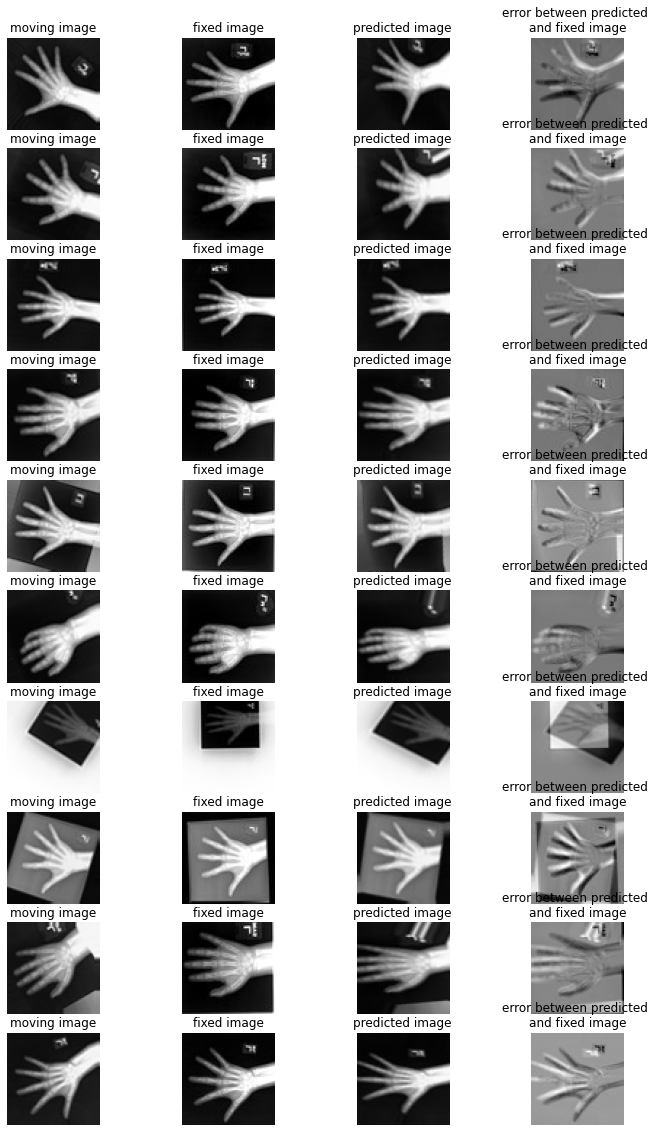

In [14]:
%matplotlib inline
batch_size = 10
plt.subplots(batch_size, 4, figsize=(12, 20))
for b in range(batch_size):
    # moving image
    plt.subplot(batch_size, 4, b * 4 + 1)
    plt.axis('off')
    plt.title("moving image")
    plt.imshow(moving_image[b], cmap="gray")
    # fixed image
    plt.subplot(batch_size, 4, b * 4 + 2)
    plt.axis('off')
    plt.title("fixed image")
    plt.imshow(fixed_image[b], cmap="gray")
    # warped moving
    plt.subplot(batch_size, 4, b * 4 + 3)
    plt.axis('off')
    plt.title("predicted image")
    plt.imshow(pred_image[b], cmap="gray")
    
    #error
    plt.subplot(batch_size, 4, b * 4 + 4)
    plt.axis('off')
    plt.title("error between predicted \nand fixed image")
    plt.imshow(pred_image[b] - fixed_image[b], cmap="gray")
plt.axis('off')
plt.show()